# 计算图优化

元张量函数变化 ---> 计算图高层变化

In [23]:
from __future__ import annotations
import numpy as np
import tvm
from tvm import te
from tvm import relax, topi
from tvm.ir.module import IRModule
from tvm.script import tir as T
from tvm.script import relax as R
import IPython


## 模式匹配与改写

In [24]:
@tvm.script.ir_module
class MyModule:
    @R.function
    def main(x: R.Tensor((3, 4), 'float32'), y: R.Tensor((3, 4), 'float32')):
        with R.dataflow():
            lv0 = R.multiply(x, y)
            gv0 = R.add(lv0, y)
            # R.ewise_fma()
            R.output(gv0)
        return gv0

In [25]:
IPython.display.Code(MyModule.script(),language='python')
# ex = relax.vm.build(MyModule, target='llvm')

# from tvm.script import ir as I
# from tvm.script import relax as R

@I.ir_module
class Module:
    @R.function
    def main(x: R.Tensor((3, 4), dtype="float32"), y: R.Tensor((3, 4), dtype="float32")) -> R.Tensor((3, 4), dtype="float32"):
        with R.dataflow():
            lv0: R.Tensor((3, 4), dtype="float32") = R.multiply(x, y)
            gv0: R.Tensor((3, 4), dtype="float32") = R.add(lv0, y)
            R.output(gv0)
        return gv0

In [26]:
relax_func = MyModule["main"] # relax.Function
# tvm.relax.expr.Function with params
relax_func.params

[x, y]


1.IRModule ---> 2.relax.Function ---> 3.relax.expr.Var + relax.expr.SeqExpr(binding blocks) ---> 4.relax.expr.DataflowBlock ---> 5.relax.expr.VarBinding \
1.MyModule ---> 2.MyModule['main] | relax_func ---> 3.relax_func.params + relax_func.body ---> 4.func_body.blocks ---> 5.dataflow_block.bindings ---> binding.var/value 

```python
@tvm.script.ir_module
class MyModule:
    @R.function
    def main(x: Tensor((3, 4), "float32"), y: Tensor((3, 4), "float32")):
        with relax.dataflow():
            lv0 = relax.multiply(x, y)
            gv0 = relax.add(lv0, y)
            relax.output(gv0)
        return gv0
```

In [27]:
func_body = relax_func.body
type(func_body)

tvm.relax.expr.SeqExpr

In [28]:
func_body.blocks

[x: R.Tensor((3, 4), dtype="float32")
y: R.Tensor((3, 4), dtype="float32")
with R.dataflow():
    lv0: R.Tensor((3, 4), dtype="float32") = R.multiply(x, y)
    gv0: R.Tensor((3, 4), dtype="float32") = R.add(lv0, y)
    R.output(gv0)]

In [29]:
print(func_body.blocks[0])

x: R.Tensor((3, 4), dtype="float32")
y: R.Tensor((3, 4), dtype="float32")
with R.dataflow():
    lv0: R.Tensor((3, 4), dtype="float32") = R.multiply(x, y)
    gv0: R.Tensor((3, 4), dtype="float32") = R.add(lv0, y)
    R.output(gv0)


In [30]:
@R.function
def demo(x: R.Tensor((1, 10)), w: R.Tensor((10, 10))):
    with R.dataflow():
        lv0 = relax.op.linear(x, w)
        R.output(lv0)
    return lv0

In [31]:
demo.body.blocks[0].bindings[0].value.args[0].struct_info.shape[1]

T.int64(10)

**访问者模式 (visitor pattern)** 的设计模式，它允许我们访问每个 AST 节点并将它们重写为转换后的版本。

In [32]:
@relax.expr_functor.mutator
class EwiseFMARewriter(relax.PyExprMutator):
    def visit_call_(self, call):
        print(call.op, type(call.op))
        call = self.visit_expr_post_order(call)
        add_op = tvm.ir.Op.get("relax.add")
        multiply_op = tvm.ir.Op.get("relax.multiply")
        ewise_fma_op = tvm.ir.Op.get("relax.ewise_fma")

        if call.op != add_op:
            return call
        value = self.lookup_binding(call.args[0])
        print(call, type(call), type(call.args[0]), value)
        if not isinstance(value, relax.Call) or value.op != multiply_op:
            return call

        fma_call = relax.Call(
            ewise_fma_op, [value.args[0], value.args[1], call.args[1]], None, None
        )
        return fma_call


updated_fn = EwiseFMARewriter().visit_expr(MyModule["main"])
# 依次访问每个AST节点
import IPython
IPython.display.Code(updated_fn.script(),language='python')

Op(relax.multiply) <class 'tvm.ir.op.Op'>
Op(relax.add) <class 'tvm.ir.op.Op'>
R.add(lv0, y) <class 'tvm.relax.expr.Call'> <class 'tvm.relax.expr.DataflowVar'> R.multiply(x, y)


# from tvm.script import relax as R

@R.function
def main(x: R.Tensor((3, 4), dtype="float32"), y: R.Tensor((3, 4), dtype="float32")) -> R.Tensor((3, 4), dtype="float32"):
    with R.dataflow():
        lv0: R.Tensor((3, 4), dtype="float32") = R.multiply(x, y)
        gv0: R.Tensor((3, 4), dtype="float32") = R.ewise_fma(x, y, y)
        R.output(gv0)
    return gv0

relax.analysis.remove_all_unused消除死代码

In [33]:
IPython.display.Code(relax.analysis.remove_all_unused(updated_fn).script(),language='python')

# from tvm.script import relax as R

@R.function
def main(x: R.Tensor((3, 4), dtype="float32"), y: R.Tensor((3, 4), dtype="float32")) -> R.Tensor((3, 4), dtype="float32"):
    with R.dataflow():
        gv0: R.Tensor((3, 4), dtype="float32") = R.ewise_fma(x, y, y)
        R.output(gv0)
    return gv0

In [34]:
module = IRModule.from_expr(updated_fn)
module['main'].with_attr("Primitive", 1)

# from tvm.script import relax as R

@R.function
def main(x: R.Tensor((3, 4), dtype="float32"), y: R.Tensor((3, 4), dtype="float32")) -> R.Tensor((3, 4), dtype="float32"):
    R.func_attr({"Primitive": 1})
    with R.dataflow():
        lv0: R.Tensor((3, 4), dtype="float32") = R.multiply(x, y)
        gv0: R.Tensor((3, 4), dtype="float32") = R.ewise_fma(x, y, y)
        R.output(gv0)
    return gv0

## 融合Dense与Add算子

In [35]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", 'rb'))

In [36]:
def create_model():
    bb = relax.BlockBuilder()
    x = relax.Var('x', R.Tensor((1, 784), dtype='float32'))
    w0 = relax.const(mlp_params['w0'], dtype='float32')
    b0 = relax.const(mlp_params['b0'], 'float32')
    w1 = relax.const(mlp_params['w1'], 'float32')
    b1 = relax.const(mlp_params['b1'], 'float32')

    with bb.function('main', [x,]):
        with bb.dataflow():
            lv0 = bb.emit(relax.op.linear(x, w0))
            lv1 = bb.emit(relax.op.add(lv0, b0))
            lv2 = bb.emit(relax.op.nn.relu(lv1))
            lv3 = bb.emit(relax.op.linear(lv2, w1))
            lv4 = bb.emit(relax.op.add(lv3, b1))
            gv = bb.emit_output(lv4)
        bb.emit_func_output(gv)
    
    return bb.get()

MLPModel = create_model()
MLPModel.show()

/staff/qiaoliang/anaconda3/envs/MLC/lib/python3.8/site-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/staff/qiaoliang/anaconda3/envs/MLC/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


以下代码通过以下步骤实现：
1. 识别 dense 和 add 算子。
2. 生成另一个调用 dense 和 add 算子的子函数。
3. 将 dense 和 add 替换为融合后的子函数。

In [37]:
@relax.expr_functor.mutator
class DenseAddFusor(relax.PyExprMutator):
    def __init__(self, mod: IRModule) -> None:
        super().__init__()
        self.mod_ = mod
        # cache pre-defined ops
        # permute -> matmul -> add
        self.add_op = tvm.ir.Op.get("relax.add")
        self.permute_op = tvm.ir.Op.get("relax.permute_dims")
        self.matmul_op = tvm.ir.Op.get("relax.matmul")
        self.counter = 0

    def transform(self) -> IRModule:
        for global_var, func in self.mod_.functions.items():
            if not isinstance(func, relax.Function):
                continue
            # avoid already fused primitive functions
            if func.attrs is not None and "Primitive" in func.attrs.keys() and func.attrs["Primitive"] != 0:
                continue
            updated_func = self.visit_expr(func)
            updated_func = relax.analysis.remove_all_unused(updated_func)
            self.builder_.update_func(global_var, updated_func)

        return self.builder_.get()

    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)

        def match_call(node, op):
            if not isinstance(node, relax.Call):
                return False
            return node.op == op

        # pattern match dense => add
        if not match_call(call, self.add_op):
            return call

        value = self.lookup_binding(call.args[0])
        if value is None:
            return call

        if not match_call(value, self.matmul_op):
            return call
        
        value_1 = self.lookup_binding(value.args[1])
        if not match_call(value_1, self.permute_op):
            return call

        x = value.args[0]
        w = value_1.args[0]
        b = call.args[1]

        # construct a new fused primitive function
        param_x = relax.Var("x", x.struct_info)
        param_w = relax.Var("w", w.struct_info)
        param_b = relax.Var("b", b.struct_info)

        bb = relax.BlockBuilder()

        fn_name = "fused_dense_add%d" % (self.counter)
        self.counter += 1
        with bb.function(fn_name, [param_x, param_w, param_b]):
            with bb.dataflow():
                lv0 = bb.emit(relax.op.linear(param_x, param_w))
                gv = bb.emit_output(relax.op.add(lv0, param_b))
            bb.emit_func_output(gv)

        # Add Primitive attribute to the fused funtions
        fused_fn = bb.get()[fn_name].with_attr("Primitive", 1)
        global_var = self.builder_.add_func(fused_fn, fn_name)

        # construct call into the fused function
        return relax.Call(global_var, [x, w, b], None, None)

@tvm.ir.transform.module_pass(opt_level=2, name="DeseAddFuse")
class FuseDenseAddPass:
    """The wrapper for the LowerTensorIR pass."""
    def transform_module(self, mod, ctx):
        return DenseAddFusor(mod).transform()


MLPFused = FuseDenseAddPass()(MLPModel)
MLPFused.show()

/staff/qiaoliang/anaconda3/envs/MLC/lib/python3.8/site-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/staff/qiaoliang/anaconda3/envs/MLC/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


## 7.5 映射到TensorIR Call
我们需要将这些高级原语运算转换为相应的 TensorIR 函数（或调用库函数）。

In [38]:
tvm.ir.Op.get('relax.matmul')

Op(relax.matmul)

In [70]:
@relax.expr_functor.mutator
class LowerToTensorIR(relax.PyExprMutator):
    def __init__(self, mod: IRModule, op_map):
        super().__init__()
        self.mod_ = mod
        self.op_map = {
            tvm.ir.Op.get(k): v for k, v in op_map.items()
        }
        self.matmul_op = tvm.ir.Op.get("relax.matmul")

    def visit_call_(self, call: relax.Call):
        call = self.visit_expr_post_order(call)
        
        def match_call(node, op):
            if not isinstance(node, relax.Call):
                return False
            return node.op == op

        if call.op in self.op_map:
            call_pre = None
            if match_call(call, self.matmul_op):
                call_pre = self.lookup_binding(call.args[1])
            
            return self.op_map[call.op](self.builder_, call, call_pre)
        return call
    
    def transform(self):
        for global_var, func in self.mod_.functions.items():
            if not isinstance(func, relax.Function):
                continue
            updated_fn = self.visit_expr(func)
            updated_fn = relax.analysis.remove_all_unused(updated_fn)
            self.builder_.update_func(global_var, updated_fn)
        
        return self.builder_.get()
    
def map_add(bb: relax.BlockBuilder, call: relax.Call, call_pre: relax.Call = None):
    x, b = call.args
    return bb.call_te(topi.add, x, b)

def map_matmul(bb: relax.BlockBuilder, call: relax.Call, call_pre: relax.Call = None):
    x, w = call.args
    print(call, call_pre)
    if call_pre.op == tvm.ir.Op.get("relax.permute_dims"):
        w = call_pre.args[0]
        return bb.call_te(topi.nn.dense, x, w)
    return bb.call_te(topi.matmul, x, w)

def map_relu(bb, call, call_pre=None):
    return bb.call_te(topi.nn.relu, call.args[0])

op_map = {
  "relax.matmul": map_matmul,
  "relax.add": map_add,
  "relax.nn.relu": map_relu
}

@tvm.ir.transform.module_pass(opt_level=0, name="LowerToTensorIR")
class LowerToTensorIRPass:
    """The wrapper for the LowerTensorIR pass."""
    def transform_module(self, mod, ctx):
        return LowerToTensorIR(mod, op_map).transform()


MLPModelTIR = LowerToTensorIRPass()(MLPFused)
MLPModelTIR.show()

R.matmul(x, lv, out_dtype="void") R.permute_dims(w, axes=None)
R.matmul(x, lv, out_dtype="void") R.permute_dims(w, axes=None)


/staff/qiaoliang/anaconda3/envs/MLC/lib/python3.8/site-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/staff/qiaoliang/anaconda3/envs/MLC/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


In [71]:
MLPModelFinal = relax.transform.FuseTIR()(MLPModelTIR)
MLPModelFinal.show()

/staff/qiaoliang/anaconda3/envs/MLC/lib/python3.8/site-packages/tvm/script/highlight.py:117: UserWarning: No module named 'black'
To print formatted TVM script, please install the formatter 'Black':
/staff/qiaoliang/anaconda3/envs/MLC/bin/python -m pip install "black==22.3.0" --upgrade --user
  warnings.warn(


## 7.6 构建运行

In [73]:
# Hide outputs
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

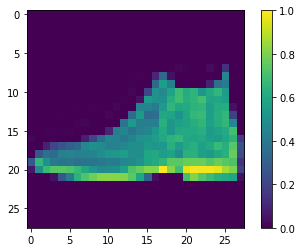

Class: Ankle boot


In [74]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [75]:
ex = relax.vm.build(MLPModelFinal, target='llvm')
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MLPModule Prediction:", class_names[pred_kind[0]])

MLPModule Prediction: Ankle boot
